In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from flask import Flask, render_template, request

#### **== READ DATASET ==**

In [3]:
df = pd.read_excel("src/dataset.xlsx")

Sebelum lanjut ke tahap preprocessing, ada baiknya diketahui persebaran jumlah data yang ada. Persebaran rating tiap teks dapat dilihat pada program dibawah.

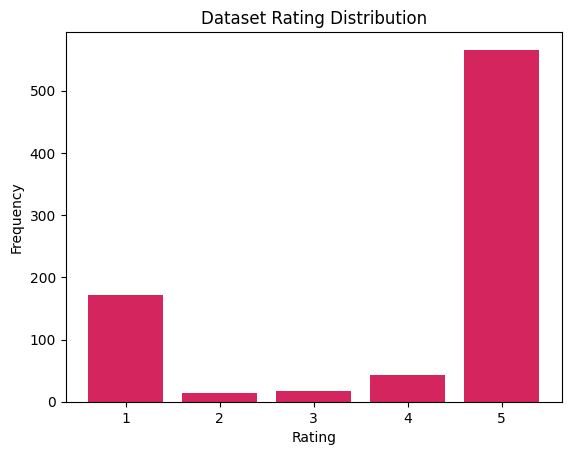

In [6]:
ratings_distribution = df['review_rating'].value_counts().sort_index()

# Plotting Jumlah Sentimen
plt.bar(ratings_distribution.index, ratings_distribution.values, color = "#D5255E")
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Dataset Rating Distribution')
plt.show()

#### **== PREPROCESSING TEXT ==**

*Preprocessing Text* merupakan proses untuk merubah bentuk teks yang digunakan nantinya untuk memudahkan proses analisis sentimen. Dalam menganalisis sebuah sentiman dalam teks tentunya teks tersebut harus mengandung kata yang melambangkan nilai teks tersebut sehingga nantinya dapat dikategorikan kedalam sentimen positif atau negatif. *Preprocessing Text* terdiri dari beberapa tahapan yaitu. 
1. **Case Folding**
2. **Normalisasi Teks**
3. **Stopword Removal**
4. **Stemming**

In [7]:
import string
import re
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Diputra_W\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##### **1. CASE FOLDING**
Case Folding merupakan proses untuk membersihkan noise pada teks. Pembersihan noise disini berarti penyeragaman penulisan teks yang diberikan. Beberapa bentuk case folding yaitu.
1. **Lower Case**, merubah menjadi huruf *non-kapital*. Sebetulnya bisa menggunakan *upper-case* untuk merubah ke bentuk huruf kapital namun lebih sering dilakukan *lower-case*.
2. **Removing Numbers**, menghilangkan angka dan simbol.
3. **Remove Punctuation**, menghilangkan tanda baca (".", ",", ":", dsb)
4. **Remove Whitespace**, menghilangkan spasi tambahan pada pinggir kalimat.
5. **Remove Emojis**, menghilangkan emoji pada teks.

In [10]:
def case_folding(sentence):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # Emojis in the first range
        u"\U0001F300-\U0001F5FF"  # Emojis in the second range
        u"\U0001F680-\U0001F6FF"  # Emojis in the third range
        u"\U0001F700-\U0001F77F"  # Emojis in the fourth range
        u"\U0001F780-\U0001F7FF"  # Emojis in the fifth range
        u"\U0001F800-\U0001F8FF"  # Emojis in the sixth range
        u"\U0001F900-\U0001F9FF"  # Emojis in the seventh range
        u"\U0001FA00-\U0001FA6F"  # Emojis in the eighth range
        u"\U0001FA70-\U0001FAFF"  # Emojis in the ninth range
        u"\U0001F004-\U0001F0CF"  # Emojis in the tenth range
        "]+", flags=re.UNICODE)

    sentence = emoji_pattern.sub(r'', sentence)
    sentence = sentence.translate(str.maketrans("","", string.punctuation)).lower()
    sentence = re.sub(r"\d+", "", sentence)
    sentence = sentence.replace("/", " ")
    return sentence


##### **2. NORMALIZE TEXT**
*Normalize Text* atau normalisasi merupakan proses untuk merubah atau memperbaiki setiap kesalahan penulisan/ejaan pada teks. Normalisasi teks biasanya dilakukan dengan bantuan kamus khusus yang terdiri dari ejaan kata yang salah dengan bentuk ejaan yang benar. Kemudian kamus ini diaplikasikan pada teks yang diuji. Contoh sebagai berikut : 
- yg = yang
- jd, jdi = jadi
- gak, ga, tdk, ngga, nggak, nggk = tidak
- dll

In [11]:
def load_abbreviation_file(file_path):
    try:
        with open(file_path, "r") as file:
            abbreviations = json.load(file)
        return abbreviations
    except FileExistsError:
        print(f"File not found {file_path}")
        return {}

#Reading the abbreviation file path for preprocessing
file_path = "abbreviation_file.txt"
abbreviation_file = load_abbreviation_file(file_path)

def normalize_text(sentence):
    words = sentence.lower().split()
    words_normalized = []
    for word in words:
        for full_form, abbreviations in abbreviation_file.items():
            if word.lower() in abbreviations:
                words_normalized.append(full_form)
                break
        else:
            words_normalized.append(word)
    return " ".join(words_normalized)

##### **3. STOPWORD REMOVAL**
*Stopword* merupakan list kata tidak penting yang terdapat dalam teks namun tidak melambangkan isi atau nilai dari teks tersebut. Contoh bentuk *stopword* yaitu kata depan, kata hubung, dan kata ganti orang. 
- Kata depan : di, ke, dari.
- Kata hubung : dan, atau, karena.
- Kata ganti orang : mereka, dia, kamu.

Terdapat metode lain dalam proses ini yang dapat dilakukan yaitu __*Wordlist*__ namun metode ini kurang efisien karena metode *wordlist* merupakan kebalikan dari *stopword removal* yang akan membiarkan kata yang dinilai penting dan melambangkan isi teks. Kebanyakan kata dalam *wordlist* berupa kata teknis, ilmiah, dan baku sehingga jika dibuatkan kamus tentu akan memakan banyak waktu.

In [12]:
def stopwords_removal(sentence):
    tokens = word_tokenize(sentence)
    liststopwords =  set(stopwords.words('indonesian'))

    custom_stopwords_file = "more_stopwords.txt"

    custom_stopwords = set()
    with open(custom_stopwords_file, "r") as file:
        for line in file:
            custom_stopwords.add(line.strip())

    combined_stopwords = liststopwords.union(custom_stopwords)

    with open(custom_stopwords_file, "w") as file:
        for word in combined_stopwords:
            file.write(word + "\n")

def remove_custom_stopwords(sentence, custom_stopwords_file):
    custom_stopwords = set()
    with open(custom_stopwords_file, 'r') as file:
        for line in file:
            custom_stopwords.add(line.strip())

    words = word_tokenize(sentence)

    filtered_words = [word for word in words if word.lower() not in custom_stopwords]

    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

##### **4. STEMMING TEXT**
Stemming merupakan proses untuk mengubah setiap kata yang ada dalam kelimat ke bentuk kata dasarnya. Jika dalam kalimat sebuah kata sudah dalam bentuk kata dasar makan kata tersebut akan diabaikan. Contoh *Stemming* sebagai berikut.
- berjalan, menjalankan = jalan

Stemming merupakan proses mengubah kata pada kalimat menjadi bentuk kata dasarnya

In [13]:
def stemming_text(sentence):
    factory = StemmerFactory()
    Stemmer = factory.create_stemmer()

    sentence = Stemmer.stem(sentence)
    return sentence

In [14]:
df['case_folding'] = df['review_text'].apply(case_folding)
df['normalized_text'] = df['case_folding'].apply(normalize_text)
df['stopword_removed'] = df['normalized_text'].apply(lambda x: remove_custom_stopwords(x, 'more_stopwords.txt'))
df['stemmed_text'] = df['stopword_removed'].apply(stemming_text)
pd.set_option('display.max_colwidth', None)
df.head(1)

,author_title,review_rating,review_text,case_folding,normalized_text,stopword_removed,stemmed_text
0,Felix zhang,5,"Urus KTP hilang cukup surat keterangan hilang dari kepolisian dan fotokopi KK\nAntrian sekitar 1 jam, proses cetak hanya sekitar 2 menit",urus ktp hilang cukup surat keterangan hilang dari kepolisian dan fotokopi kk\nantrian sekitar jam proses cetak hanya sekitar menit,urus kartu tanda penduduk hilang cukup surat keterangan hilang dari kepolisian dan fotokopi kartu keluarga antrian sekitar jam proses cetak hanya sekitar menit,urus kartu tanda penduduk hilang surat keterangan hilang kepolisian fotokopi kartu keluarga antrian jam proses cetak menit,urus kartu tanda duduk hilang surat terang hilang polisi fotokopi kartu keluarga antri jam proses cetak menit


In [15]:
dfnew = df[["stemmed_text", "review_rating"]]
dfnew.head()

,stemmed_text,review_rating
0,urus kartu tanda duduk hilang surat terang hilang polisi fotokopi kartu keluarga antri jam proses cetak menit,5
1,urus akta nikah online taring denpasar proses cetak arah kantor informasi terima email cetak akta paket kartu tanda duduk kartu keluarga terbit admin wa taring denpasar respon tanggap cepat respect admin wa nya suasana dukcapil loket layan cepat ramah tunggu nyaman antri ramai paham alur astungkara mudah cepat,5
2,layan mana buat suratsurat mudah sistem online bulakbalik penuh dokumen langsung cetak mandiri bawa ojek online tugas ramah bimbing sulit moga layan tahan tingkat terimakasih,5
3,cocok gaji staf staf dukcapil kerja nya buru buru pulang jam salah salah cetak kartu tanda duduk kartu keluarga status agama kartu tanda duduk ganti buru buru pulang kerja beres,1
4,proses cepat online riweh bingung tinggal wa admin nya layan ramah ya beda sangtta yaa sih ter the best pokok,5


In [16]:
import tensorflow
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import models

#### **== PELABELAN SENTIMEN ==**
Dalam melakukan analisis sentimen setiap rating nantinya akan dibedakan menjadi beberapa kategori. Persebaran kategori tersebut berupa.
- Rating 1 & 2 bernilai negatif
- Rating 3 Bernilai netral
- Rating 4 & 5 bernilai positif

In [17]:
label_mapping = {1: 'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'}

df_encoded = pd.DataFrame()
df_encoded['stemmed_text'] = dfnew['stemmed_text']
df_encoded['sentiment_category'] = dfnew['review_rating'].map(label_mapping)

df_encoded['sentiment_category'].fillna('Neutral', inplace=True)

label_encoder = LabelEncoder()
df_encoded['encoded_label'] = label_encoder.fit_transform(df_encoded['sentiment_category'])

df_encoded.head()

,stemmed_text,sentiment_category,encoded_label
0,urus kartu tanda duduk hilang surat terang hilang polisi fotokopi kartu keluarga antri jam proses cetak menit,Positive,2
1,urus akta nikah online taring denpasar proses cetak arah kantor informasi terima email cetak akta paket kartu tanda duduk kartu keluarga terbit admin wa taring denpasar respon tanggap cepat respect admin wa nya suasana dukcapil loket layan cepat ramah tunggu nyaman antri ramai paham alur astungkara mudah cepat,Positive,2
2,layan mana buat suratsurat mudah sistem online bulakbalik penuh dokumen langsung cetak mandiri bawa ojek online tugas ramah bimbing sulit moga layan tahan tingkat terimakasih,Positive,2
3,cocok gaji staf staf dukcapil kerja nya buru buru pulang jam salah salah cetak kartu tanda duduk kartu keluarga status agama kartu tanda duduk ganti buru buru pulang kerja beres,Negative,0
4,proses cepat online riweh bingung tinggal wa admin nya layan ramah ya beda sangtta yaa sih ter the best pokok,Positive,2


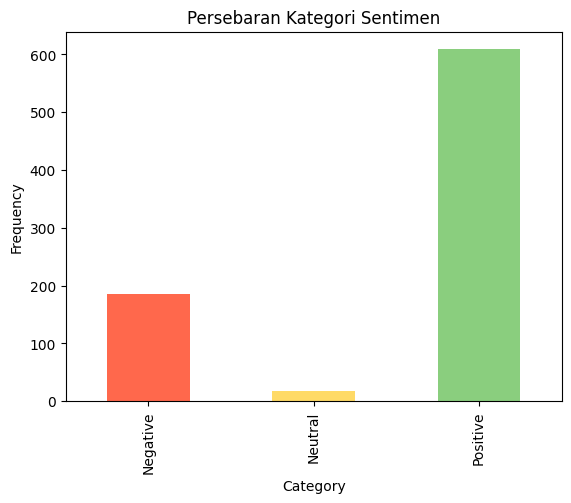

In [21]:
sentiment_order = ['Negative', 'Neutral', 'Positive']
sentiment_colors = {'Negative': '#ff684c', 'Neutral': '#ffda66', 'Positive': '#8ace7e'}

sentiment_distribution = df_encoded['sentiment_category'].value_counts().loc[sentiment_order]

sentiment_distribution.plot(kind='bar', color=[sentiment_colors[sentiment] for sentiment in sentiment_distribution.index])
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Persebaran Kategori Sentimen')
plt.show()


#### **== MODEL ANALISIS SENTIMEN ==**

Analisis sentimen dilakukan untuk membangun sebuah model yang mampu mengklasifikasikan sentimen teks apakah teks tersebut termasuk komentar positif atau negatif. Adapun beberapa tahap lanjut dalam pembentukan model tersebut yaitu.
- **Split Train & test Data**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded['stemmed_text'], df_encoded['encoded_label'], test_size=0.2, random_state=42)

- **Tokenize & Padding**

In [16]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 100  # Adjust based on your dataset
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [17]:
# Assuming you have a DataFrame df_encoded with 'text' and 'encoded_label' columns
# One-hot encode the labels
df_encoded['encoded_label'] = to_categorical(df_encoded['encoded_label'])
df_encoded.head()

,stemmed_text,sentiment_category,encoded_label
0,urus kartu tanda duduk hilang surat terang hilang polisi fotokopi kartu keluarga antri jam proses cetak menit,Positive,0.0
1,urus akta nikah online taring proses cetak arah kantor informasi terima email cetak akta paket kartu tanda duduk kartu keluarga terbit admin taring respon tanggap cepat respect admin suasana dukcapil loket layan cepat ramah tunggu nyaman antri ramai paham alur mudah cepat,Positive,0.0
2,layan mana buat suratsurat mudah sistem online bulakbalik penuh dokumen langsung cetak mandiri bawa ojek online tugas ramah bimbing sulit moga layan tahan tingkat terimakasih,Positive,0.0
3,gaji staf staf dukcapil kerja buru buru pulang jam salah salah cetak kartu tanda duduk kartu keluarga status agama kartu tanda duduk ganti buru buru pulang kerja beres,Negative,1.0
4,proses cepat online riweh bingung tinggal admin layan ramah ya beda sangtta yaa sih ter the best pokok,Positive,0.0


- **Call & Train The Model**

In [18]:
# Build a simple neural network
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_length))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=3, activation='softmax'))  # 3 output units for three categories

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, to_categorical(y_train), epochs=15, validation_data=(X_test_padded, to_categorical(y_test)))


Epoch 1/15
21/21 [==============================] - 2s 41ms/step - loss: 0.6295 - accuracy: 0.7581 - val_loss: 0.5369 - val_accuracy: 0.7607
Epoch 2/15
21/21 [==============================] - 1s 26ms/step - loss: 0.4792 - accuracy: 0.8274 - val_loss: 0.4630 - val_accuracy: 0.8589
Epoch 3/15
21/21 [==============================] - 1s 26ms/step - loss: 0.3371 - accuracy: 0.9060 - val_loss: 0.4021 - val_accuracy: 0.8650
Epoch 4/15
21/21 [==============================] - 1s 26ms/step - loss: 0.2149 - accuracy: 0.9291 - val_loss: 0.3620 - val_accuracy: 0.8773
Epoch 5/15
21/21 [==============================] - 1s 25ms/step - loss: 0.1419 - accuracy: 0.9615 - val_loss: 0.3473 - val_accuracy: 0.8834
Epoch 6/15
21/21 [==============================] - 1s 32ms/step - loss: 0.1016 - accuracy: 0.9692 - val_loss: 0.3364 - val_accuracy: 0.8896
Epoch 7/15
21/21 [==============================] - 1s 29ms/step - loss: 0.0776 - accuracy: 0.9769 - val_loss: 0.3339 - val_accuracy: 0.8834
Epoch 8/15
21

- **Save The Model**

In [19]:
#Save the model and tokenizer
model.save('sentiment_model.h5')
tokenizer_config = tokenizer.get_config()
tokenizer_config['num_words'] = max_words
with open('tokenizer_config.json', 'w') as config_file:
    config_file.write(json.dumps(tokenizer_config))